# Data Exploration
## Purpose
State the purpose of the notebook.
## Methodology
Quickly describle assumptions and processing steps.
## WIP - improvements
Use this section only if the notebook is not final.

Notable TODOs:

- Todo 1;
- Todo 2;

## Results
Describe and comment the most important results.

# Setup
## Library import
We import all the required Python libraries

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray
import rasterio
import regionmask
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Utils

**set_lat_lon_attrs**

In [2]:
def set_lat_lon_attrs(ds):
    """ Set CF latitude and longitude attributes"""
    ds["lon"] = ds.lon.assign_attrs({
      'axis' : 'X',
       'long_name' : 'longitude',
        'standard_name' : 'longitude',
         'stored_direction' : 'increasing',
          'type' : 'double',
           'units' : 'degrees_east',
            'valid_max' : 360.0,
             'valid_min' : -180.0
             })
    ds["lat"] = ds.lat.assign_attrs({
      'axis' : 'Y',
       'long_name' : 'latitude',
        'standard_name' : 'latitude',
         'stored_direction' : 'increasing',
          'type' : 'double',
           'units' : 'degrees_north',
            'valid_max' : 90.0,
             'valid_min' : -90.0
             })
    return ds

**create_ds_mask**

In [3]:
def create_ds_mask(df, ds, name, lon_name='lon', lat_name='lat'):
    """Create masks of geographical regions"""
    # Create index column
    if 'index' not in df:
        df = df.reset_index(drop=True).reset_index()

    # Extract indexes and geoms that are large enough!
    id_ints = df['index'].values
    geoms = df['geometry'].values
    
    print(f'Number of indexes: {len(id_ints)}')
    print(f'Number of geoms: {len(geoms)}')


    # create mask object
    da_mask = regionmask.Regions(
      name = name,
      numbers = id_ints,
      outlines = geoms)\
      .mask(ds, lon_name=lon_name, lat_name=lat_name)\
      .rename(name)

    # get the ints actually written to mask
    id_ints_mask = da_mask.to_dataframe().dropna()[name].unique()
    id_ints_mask = np.sort(id_ints_mask).astype('int')
    
    print(f'Number of ints in mask: {len(id_ints_mask)}')
    
    # get the ints not written to mask
    id_ints_not_in_mask = df[~df['index'].isin(id_ints_mask)]['index'].values
    
    if len(id_ints_not_in_mask) > 0: 
        print(f'Ints not in mask: {id_ints_not_in_mask}')
    
    # update da attributes
    da_mask.attrs['id_ints'] = id_ints_mask
    da_mask = set_lat_lon_attrs(da_mask)
    
    return da_mask, id_ints_not_in_mask

**find_nearest**

In [4]:
def find_nearest(array, value):
    """Find nearest value in numpy array"""
    array = np.asarray(array)
    
    # Get the mean step values
    step = np.abs(np.diff(array)).max()
    
    # Find the nearest values
    diff = np.abs(array - value)
    idx = np.argwhere((diff >= np.amin(diff) - step) & (diff <= np.amin(diff) + step))

    return idx

**get_xy_from_latlon**

In [5]:
def get_xy_from_latlon(ds, lat, lon):
    """Return the x/y values for a given longitude/latitude values"""
    # Read all lon/lat values
    lons = ds.lon.data
    lats = ds.lat.data
    
    # Find the positions of the nearest longitude/latitude values
    idx_lon = find_nearest(lons, lon)
    idx_lat = find_nearest(lats, lat)
    
    # Check the identical rows in both arrays
    res = (idx_lon[:, None] == idx_lat).all(-1).any(-1)
    yx_positions = idx_lon[res]
    
    
    if yx_positions.shape[0] == 0:
        raise Exception("Sorry, lat/lon values outside data domain")   
    if yx_positions.shape[0] > 1:
        # If more than one identical rows take the row nearest to the mean value
        yx_positions = np.mean(yx_positions,axis=0).astype(int).reshape(1,2)

    # Get the x/y values
    x_position = yx_positions[0][1]
    y_position = yx_positions[0][0]
    x = ds.rlon.data[yx_positions[0][1]]
    y = ds.rlat.data[yx_positions[0][0]]

    return x_position, y_position, x, y

# Data import

## Comarcas Agrarias
**[Data source](https://www.mapa.gob.es/es/cartografia-y-sig/ide/descargas/agricultura/)**

La distribución de la superficie de España en `Comarcas Agrarias` agrupa los territorios en unidades espaciales intermedias entre la provincia y el municipio que sin personalidad jurídico-administrativa alguna, tiene un carácter uniforme desde el punto de vista agrario.

In [6]:
comarcas_agr = gpd.read_file(f'../../datasets/raw/georegions/ComarcasAgrarias/ComarcasAgrarias.shp')
comarcas_agr.sort_values(['CO_CCAA', 'CO_PROVINC', 'CO_COMARCA'], inplace = True)

Remove Canarias, Ceuta, and Melilla

In [7]:
comarcas_agr = comarcas_agr[~comarcas_agr['DS_CCAA'].isin(['Canarias', 'Ceuta', 'Melilla'])]
comarcas_agr = comarcas_agr.reset_index(drop=True)

**Display geometries**

<AxesSubplot:>

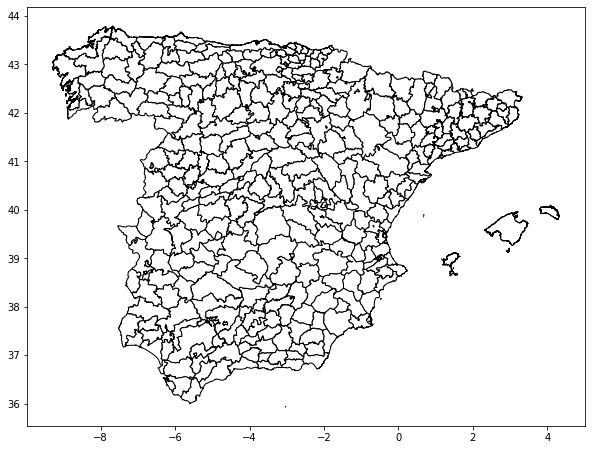

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
comarcas_agr.plot(ax=ax, color='w', edgecolor='k')

## Municipios de España

**[Data source](https://opendata.esri.es/datasets/53229f5912e04f1ba6dddb70a5abeb72_0/explore?location=43.017075%2C9.288571%2C5.20)**

In [9]:
municipios = gpd.read_file(f'../../datasets/raw/georegions/Municipios/Municipios_IGN.shp')
municipios.sort_values(['CODNUT1', 'CODNUT2', 'CODNUT3', 'CODIGOINE'], inplace = True)

Remove Canarias, Ceuta, and Melilla

In [10]:
municipios = municipios[~municipios['CODNUT2'].isin(['ES70', 'ES63', 'ES64'])]
municipios = municipios.reset_index(drop=True)

**Display geometries**

<AxesSubplot:>

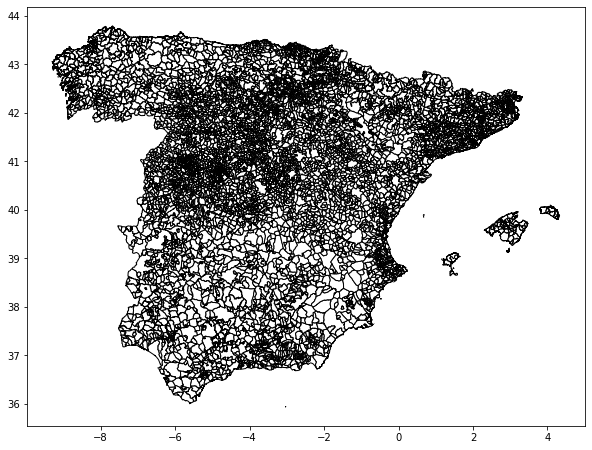

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
municipios.plot(ax=ax, color='w', edgecolor='k')

## Fire danger indicators for Europe 
**[Data source](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-tourism-fire-danger-indicators?tab=overview)**

The dataset presents projections of fire danger indicators for Europe based upon the Canadian Fire Weather Index System (FWI) under future climate conditions. The FWI is a meteorologically based index used worldwide to estimate the fire danger and is implemented in the Global ECMWF Fire Forecasting model (GEFF).

**Variables:**
- **Seasonal fire weather index:** 
The mean fire weather index value over the European fire season (June-September). This is calculated as the sum of the daily fire weather index over the European fire season divided by the total number of days within this date range. The higher the index value, the more favorable the meteorological conditions to trigger a wildfire are.

**Read data**

In [ ]:
data_dir = '../../datasets/raw/climate/dataset-sis-tourism-fire-danger-indicators/'
for n, file in enumerate(os.listdir(data_dir)[16:]):
    # convert to Dataset and concatenate by time
    if n == 0:
        ds_fire = xr.open_dataset(data_dir+file, engine="netcdf4")
    else:
        ds = xr.open_dataset(data_dir+file, engine="netcdf4")
        ds_fire = xr.concat([ds_fire, ds], dim='time')

In [ ]:
ds_fire

**Multidimensional Coordinates**

The data will derive from a numerical model in which the poles of the model's coordinate system (`logical coordinates`) differ from the earth's true poles (`physical coordinates`). This is typically done when running limited area models, in order to keep the poles as far away as possible from the area that is being modelled. This allows the model's resolution to be roughly uniform over the model domain, as the coordinate system is then approximately cartesian and avoids issues where the meridians converge close to the poles.

In our dataset, the `logical coordinates` are `rlon` and `rlat`, while the physical coordinates are `lon` and `lat`, which represent the latitudes and longitude of the data.

In [ ]:
print(ds_fire.rlon.attrs)
print(ds_fire.rlat.attrs)

In [ ]:
print(ds_fire.lon.attrs)
print(ds_fire.lat.attrs)

**Display data**

Xarray provides [several ways](http://xarray.pydata.org/en/stable/examples/multidimensional-coords.html) to plot and analyze such datasets.

If we try to plot the data variable `fwi-mean-jjas`, by default we get the logical coordinates.

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))
ds_fire['fwi-mean-jjas'].isel(time=0).plot(ax=axs[0])
ds_fire['fwi-mean-jjas'].isel(time=-1).plot(ax=axs[1])

In order to visualize the data on a conventional latitude-longitude grid, we can take advantage of xarray’s ability to apply [cartopy](http://scitools.org.uk/cartopy/index.html) map projections.

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ds_fire['fwi-mean-jjas'].isel(time=0).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=False)
ax.coastlines()
ax.set_ylim([0,90]);
ax.set_xlim([-30,70]);

## Rasterize vector data

### Compute mean values for each `comarca agraria`

**Create the data mask by rasterizing the vector data**

In [ ]:
gdf = comarcas_agr.copy()
gdf = gdf.reset_index(drop=True)
da_mask, id_ints_not_in_mask = create_ds_mask(gdf, ds_fire, name='mask', lon_name='lon', lat_name='lat')

In [ ]:
da_mask

**Add geometries smaller than mean cell size into the mask**

In [ ]:
gdf_not_in_mask = gdf.iloc[id_ints_not_in_mask].copy()

gdf_not_in_mask['centroid'] = gdf_not_in_mask['geometry'].apply(lambda x: x.centroid)

for id_int in id_ints_not_in_mask:
    lon = gdf_not_in_mask['centroid'].loc[id_int].x
    lat = gdf_not_in_mask['centroid'].loc[id_int].y
    
    # Get x/y values for the corresponding longitude/latitude values
    x_pos, y_pos, x, y = get_xy_from_latlon(ds_fire, lat, lon)
    
    # Replace cell value with new int
    da_mask.data[y_pos, x_pos] = id_int
    
# update da attributes
da_mask.attrs['id_ints'] = list(gdf.index)

**Display mask**

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
da_mask.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=False)
ax.coastlines()
ax.set_ylim([35, 45]);
ax.set_xlim([-10, 5]);

**Add mask as a new variable into the xarray.Dataset**

In [ ]:
ds_fire['mask'] = da_mask

**Compute mean value over time**

In [ ]:
mean_values = [] 
for index in gdf.index:
    mean_values.append(ds_fire['fwi-mean-jjas'].where(ds_fire.mask == index).mean(['rlon', 'rlat']).values)
    
gdf['fire'] = mean_values
gdf['time'] = [list(ds_fire.coords['time'].values)]*len(mean_values)

**Display values for a single year**

In [ ]:
year = 0
gdf_1year = gdf.copy()
gdf_1year['fire'] = gdf_1year['fire'].apply(lambda x: x[year])
gdf_1year['time'] = gdf_1year['time'].apply(lambda x: x[year])

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=-0.5)

gdf_1year.plot(ax=ax, column='fire', cmap='magma', legend=True, cax=cax, legend_kwds={'label': "Seasonal fire weather index"})

ax.set_title(str(gdf_1year['time'].iloc[0]))

## European OpenGHGMap 
**[Data source](https://openghgmap.net/data/)**

This project maps CO2 emissions across Europe. The aim is to estimate an emissions inventory for each of the ~116 000 administrative jurisdictions across Europe and the UK.

The model spatially disaggregates each country's official (Eurostat) CO2 emissions inventory to places using OpenStreetMap. Vehicle emissions are attributed across fuel stations, train emissions at stations, aviation bunker fuel emissions at airports, and so on. Industrial source emissions are located at the registered address where these emissions phyiscally occur or are legally controlled. Data are for the year 2018.

**Variables:**
- **Emissions:** 
The data are for the year 2018. Emissions are reported in units of metric tonnes (t) CO2.

**Read data**

In [137]:
gdf_ghg = gpd.read_file('../../datasets/raw/climate/data-OpenGHGMap/spain/8.geojson')

Merge Polygons of duplicated rows into a MultiPolygon

In [138]:
# Drop duplicates
duplicates = gdf_ghg.duplicated(subset=['rname', 'population_2015', 'co2', 'nrid'], keep=False)

gdf_unique = gdf_ghg[~duplicates].copy()

for n, name in enumerate(gdf_ghg[duplicates]['rname'].unique()):
    gdf_name = gdf_ghg[gdf_ghg['rname'] == name].copy()
    gdf_tmp = gdf_name.iloc[:1]
    gdf_tmp['geometry'] = MultiPolygon(list(gdf_name['geometry']))

    if n == 0:
        gdf_multi = gdf_tmp.copy()
    else:
        gdf_multi = pd.concat([gdf_multi, gdf_tmp])
   
gdf_ghg = pd.concat([gdf_unique, gdf_multi])
gdf_ghg.sort_values('nrid', inplace=True)
gdf_ghg.reset_index(drop=True, inplace=True)

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [161]:
gdf_ghg

,categorized,rname,population_2015,co2,coname,coco2,nrid,geometry
0,"{'fuelstations': 6854, 'buildings': 1680}",A Arnoia,1038.871721,8534.0,spain,319762270.0,1,"POLYGON ((-8.11777 42.22533, -8.11844 42.22477..."
1,"{'fuelstations': 20562, 'buildings': 10500, 'f...",A Baña,3462.579152,31262.0,spain,319762270.0,2,"POLYGON ((-8.69229 42.92662, -8.69318 42.92694..."
2,{'buildings': 84},A Bola,1273.275046,84.0,spain,319762270.0,3,"POLYGON ((-7.89096 42.11237, -7.89809 42.11214..."
3,"{'fuelstations': 6854, 'buildings': 9828, 'far...",A Capela,1343.553445,17282.0,spain,319762270.0,4,"POLYGON ((-8.09923 43.46858, -8.09939 43.46837..."
4,"{'fuelstations': 34270, 'buildings': 4788}",A Cañiza,5124.547047,39058.0,spain,319762270.0,5,"POLYGON ((-8.22299 42.23325, -8.22326 42.22971..."
...,...,...,...,...,...,...,...,...
8149,"{'buildings': 5460, 'farms': 1100}",Òrrius,621.055142,6560.0,spain,319762270.0,8152,"POLYGON ((2.33743 41.56121, 2.33817 41.55913, ..."
8150,"{'fuelstations': 6854, 'buildings': 2184, 'ets...",Ólvega,3591.163024,11659.0,spain,319762270.0,8153,"POLYGON ((-1.92681 41.71698, -1.91928 41.71904..."
8151,"{'fuelstations': 34270, 'buildings': 25788}",Órgiva,5485.714005,60058.0,spain,319762270.0,8154,"POLYGON ((-3.31769 36.82224, -3.31759 36.82295..."
8152,"{'fuelstations': 137080, 'trains': 636, 'build...",Úbeda,33354.580041,184116.0,spain,319762270.0,8155,"MULTIPOLYGON (((-3.40416 37.90798, -3.40008 37..."


In [163]:
gdf = pd.merge(municipios, gdf_ghg[['categorized', 'rname', 'population_2015', 'co2', 'coco2']], how='left', left_on='NAMEUNIT', right_on='rname')

In [177]:
gdf[gdf['co2'].isnull()]

,FID,INSPIREID,NATCODE,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,CODIGOINE,SHAPE_Leng,SHAPE_Area,geometry,categorized,rname,population_2015,co2,coco2
61,29,ES.IGN.SIGLIM34121515064,34121515064,Paderne,ES1,ES11,ES111,15064,0.439466,0.004419,"POLYGON ((-8.21699 43.29995, -8.21582 43.30239...",NaN,NaN,NaN,NaN,NaN
72,110,ES.IGN.SIGLIM34121515075,34121515075,Sada,ES1,ES11,ES111,15075,0.354298,0.003082,"MULTIPOLYGON (((-8.29745 43.38672, -8.29739 43...",NaN,NaN,NaN,NaN,NaN
77,115,ES.IGN.SIGLIM34121515080,34121515080,Sobrado,ES1,ES11,ES111,15080,0.741477,0.013322,"POLYGON ((-8.10205 43.04224, -8.10158 43.04250...",NaN,NaN,NaN,NaN,NaN
336,4348,ES.IGN.SIGLIM34033333024,34033333024,Gijón,ES1,ES12,ES120,33024,1.022333,0.020268,"MULTIPOLYGON (((-5.59767 43.54894, -5.59777 43...",NaN,NaN,NaN,NaN,NaN
338,4350,ES.IGN.SIGLIM34033333026,34033333026,Grado,ES1,ES12,ES120,33026,0.986222,0.024047,"POLYGON ((-6.20021 43.18357, -6.20121 43.18560...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7842,3347,ES.IGN.SIGLIM34012323086,34012323086,Torredelcampo,ES6,ES61,ES616,23086,0.679937,0.018633,"POLYGON ((-4.00020 37.87851, -4.00002 37.87868...",NaN,NaN,NaN,NaN,NaN
7861,3366,ES.IGN.SIGLIM34012353050,34012353050,Cuarto del Madroño,ES6,ES61,ES616,53050,0.147152,0.000723,"POLYGON ((-2.77889 38.51067, -2.77863 38.51184...",NaN,NaN,NaN,NaN,NaN
8016,3525,ES.IGN.SIGLIM34014141052,34014141052,Lantejuela,ES6,ES61,ES618,41052,0.203927,0.001805,"POLYGON ((-5.25625 37.35593, -5.25543 37.35819...",NaN,NaN,NaN,NaN,NaN
8088,595,ES.IGN.SIGLIM34143030019,34143030019,Cieza,ES6,ES62,ES620,30019,0.833758,0.037787,"POLYGON ((-1.58954 38.30999, -1.58282 38.31347...",NaN,NaN,NaN,NaN,NaN


In [190]:
for municipio in list(gdf[gdf['co2'].isnull()]['NAMEUNIT']):
    print(municipio)

Paderne
Sada
Sobrado
Gijón
Grado
Langreo
Mieres
San Martín del Rey Aurelio
Cieza
Villaescusa
Comunidad de Campoo y Cabuérniga
Ayala/Aiara
Baños de Ebro/Mañueta
Campezo/Kanpezu
Elburgo/Burgelu
Elvillar/Bilar
Labastida/Bastida
Lanciego/Lantziego
Laudio/Llodio
Moreda de Álava/Moreda Araba
Oyón-Oion
Erriberagoitia/Ribera Alta
Erriberabeitia
Agurain/Salvatierra
San Millán/Donemiliaga
Valdegovía/Gaubea
Harana/Valle de Arana
Villabuena de Álava/Eskuernaga
Yécora/Iekora
Iruña Oka/Iruña de Oca
Comunidad de la Sierra Brava de Badaya
Parzoneria de Entzia
Hondarribia
Arrasate/Mondragón
Leintz-Gatzaga
Donostia/San Sebastián
Villabona
Parzonería general de Guipúzcoa y Álava
Mancomunidad de Amezketa y Ordizia
Karrantza Harana/Valle de Carranza
Urduña/Orduña
Sopela
Abárzuza/Abartzuza
Abaurregaina/Abaurrea Alta
Abaurrepea/Abaurrea Baja
Aibar/Oibar
Altsasu/Alsasua
Allín/Allin
Ancín/Antzin
Ansoáin/Antsoain
Aoiz/Agoitz
Aranarache/Aranaratxe
Arce/Artzi
Atez/Atetz
Ayegui/Aiegi
Basaburua
Auritz/Burguete
Burg

In [200]:
list(gdf[gdf['co2'].isnull()]['NAMEUNIT'])

['Paderne',
 'Sada',
 'Sobrado',
 'Gijón',
 'Grado',
 'Langreo',
 'Mieres',
 'San Martín del Rey Aurelio',
 'Cieza',
 'Villaescusa',
 'Comunidad de Campoo y Cabuérniga',
 'Ayala/Aiara',
 'Baños de Ebro/Mañueta',
 'Campezo/Kanpezu',
 'Elburgo/Burgelu',
 'Elvillar/Bilar',
 'Labastida/Bastida',
 'Lanciego/Lantziego',
 'Laudio/Llodio',
 'Moreda de Álava/Moreda Araba',
 'Oyón-Oion',
 'Erriberagoitia/Ribera Alta',
 'Erriberabeitia',
 'Agurain/Salvatierra',
 'San Millán/Donemiliaga',
 'Valdegovía/Gaubea',
 'Harana/Valle de Arana',
 'Villabuena de Álava/Eskuernaga',
 'Yécora/Iekora',
 'Iruña Oka/Iruña de Oca',
 'Comunidad de la Sierra Brava de Badaya',
 'Parzoneria de Entzia',
 'Hondarribia',
 'Arrasate/Mondragón',
 'Leintz-Gatzaga',
 'Donostia/San Sebastián',
 'Villabona',
 'Parzonería general de Guipúzcoa y Álava',
 'Mancomunidad de Amezketa y Ordizia',
 'Karrantza Harana/Valle de Carranza',
 'Urduña/Orduña',
 'Sopela',
 'Abárzuza/Abartzuza',
 'Abaurregaina/Abaurrea Alta',
 'Abaurrepea/Abaur

In [207]:
municipio = 'Mancomunidad de Amezketa y Ordizia'
gdf_ghg['ratio'] = gdf_ghg['rname'].apply(lambda x: levenshtein_ratio_and_distance(x, municipio, ratio_calc = True))

In [208]:
gdf_ghg[gdf_ghg['ratio'] == gdf_ghg['ratio'].max()]

,categorized,rname,population_2015,co2,coname,coco2,nrid,geometry,ratio
2170,"{'fuelstations': 0, 'buildings': 0, 'farms': 0...",Comunidad de Gete y Hacinas,0.0,0.0,spain,319762270.0,2172,"POLYGON ((-3.30167 41.96093, -3.30157 41.95842...",0.622951


In [178]:
municipios[municipios['NAMEUNIT'] == 'Gijón']

,FID,INSPIREID,NATCODE,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,CODIGOINE,SHAPE_Leng,SHAPE_Area,geometry
336,4348,ES.IGN.SIGLIM34033333024,34033333024,Gijón,ES1,ES12,ES120,33024,1.022333,0.020268,"MULTIPOLYGON (((-5.59767 43.54894, -5.59777 43..."


In [175]:
gdf_ghg[gdf_ghg['rname'] == 'GijónXixón']

,categorized,rname,population_2015,co2,coname,coco2,nrid,geometry
3110,"{'fuelstations': 315284, 'trains': 636, 'build...",GijónXixón,252480.620476,555720.0,spain,319762270.0,3112,"MULTIPOLYGON (((-5.61243 43.55269, -5.61245 43..."


<AxesSubplot:>

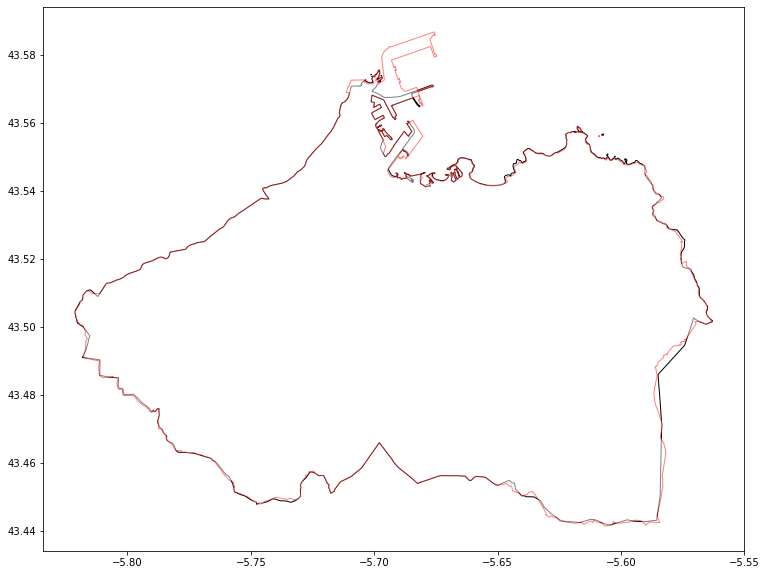

In [182]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))

municipios[municipios['NAMEUNIT'] == 'Gijón'].plot(ax=ax, color='w', edgecolor='k')
gdf_ghg[gdf_ghg['rname'] == 'GijónXixón'].plot(ax=ax, color='w', edgecolor='r', alpha=0.5)

In [183]:
def levenshtein_ratio_and_distance(s, t, ratio_calc = False):
    """ levenshtein_ratio_and_distance:
        Calculates levenshtein distance between two strings.
        If ratio_calc = True, the function computes the
        levenshtein distance ratio of similarity between two strings
        For all i and j, distance[i,j] will contain the Levenshtein
        distance between the first i characters of s and the
        first j characters of t
    """
    # Initialize matrix of zeros
    rows = len(s)+1
    cols = len(t)+1
    distance = np.zeros((rows,cols),dtype = int)

    # Populate matrix of zeros with the indeces of each character of both strings
    for i in range(1, rows):
        for k in range(1,cols):
            distance[i][0] = i
            distance[0][k] = k

    # Iterate over the matrix to compute the cost of deletions,insertions and/or substitutions    
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0 # If the characters are the same in the two strings in a given position [i,j] then the cost is 0
            else:
                # In order to align the results with those of the Python Levenshtein package, if we choose to calculate the ratio
                # the cost of a substitution is 2. If we calculate just distance, then the cost of a substitution is 1.
                if ratio_calc == True:
                    cost = 2
                else:
                    cost = 1
            distance[row][col] = min(distance[row-1][col] + 1,      # Cost of deletions
                                 distance[row][col-1] + 1,          # Cost of insertions
                                 distance[row-1][col-1] + cost)     # Cost of substitutions
    if ratio_calc == True:
        # Computation of the Levenshtein Distance Ratio
        Ratio = ((len(s)+len(t)) - distance[row][col]) / (len(s)+len(t))
        return Ratio
    else:
        # print(distance) # Uncomment if you want to see the matrix showing how the algorithm computes the cost of deletions,
        # insertions and/or substitutions
        # This is the minimum number of edits needed to convert string a to string b
        return "The strings are {} edits away".format(distance[row][col])

In [185]:
Str1 = "Gijón"
Str2 = "GijónXixón"
Distance = levenshtein_ratio_and_distance(Str1,Str2)
print(Distance)
Ratio = levenshtein_ratio_and_distance(Str1,Str2,ratio_calc = True)
print(Ratio)

The strings are 5 edits away
0.6666666666666666


Remove Canarias, Ceuta, and Melilla

In [140]:
gdf_ghg = gdf_ghg[~gdf_ghg['rname'].isin(['Ceuta', 'Melilla'])]
gdf_ghg = gdf_ghg.reset_index(drop=True)

**Display data**

<AxesSubplot:>

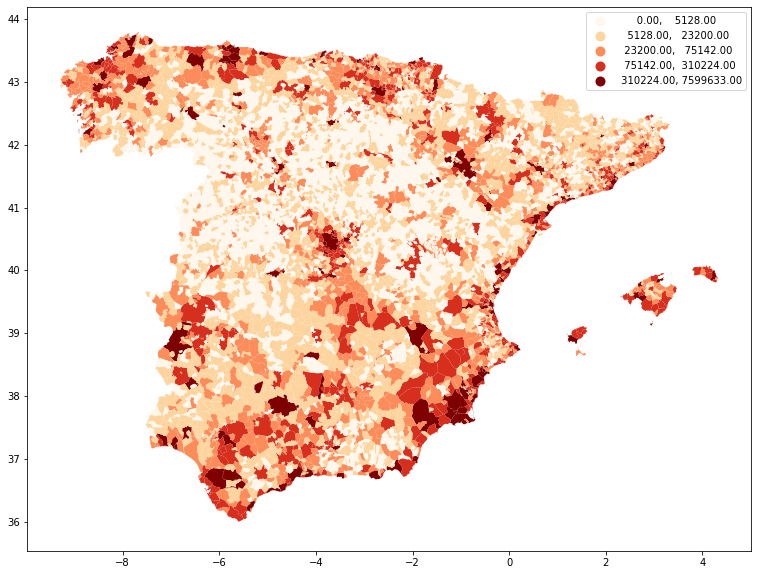

In [158]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))

gdf_ghg.plot(ax=ax, column='co2', cmap='OrRd', scheme='jenkscaspallsampled', legend=True)

## Frescor Nocturno 

In [ ]:
gdf = gpd.read_file('../../datasets/raw/vino/Resumen FRESCOR.dbf')
gdf

In [ ]:
gdf = gpd.read_file('../../datasets/raw/vino/Resumen Huglin.dbf')
gdf

In [ ]:
gdf = gpd.read_file('../../datasets/raw/vino/Resumen IS.dbf')
gdf

In [ ]:
gdf.info()

## Mapas de presencia de especies forestales en España peninsular

In [ ]:
xda = xr.open_rasterio(f'../../datasets/raw/especies_forestales/g724_mfe_pres/quer_sube.tif').squeeze().drop("band")

In [ ]:
xda

In [ ]:
# convert to Dataset
xds = xr.Dataset({'quer_sube': xda}, attrs=xda.attrs)

In [ ]:
xds

In [ ]:
xds.quer_sube.plot()

In [ ]:
xr.combine_by_coords([ds_fire, xds])